In [1]:
import os, sys
import json
import jsonlines
import numpy as np
import pandas as pd
from glob import glob
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

import cohere
import requests
import base64
import pickle
import torch

from collections import defaultdict

from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Download NLTK tokenizer resources (if not already downloaded)
nltk.download('punkt')

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/samuelcahyawijaya_cohere_com/.config/sagemaker/config.yaml


[nltk_data] Downloading package punkt to
[nltk_data]     /home/samuelcahyawijaya_cohere_com/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# Read raw data
test_data_dict = {}
docs_data_dict = {}
for path in glob('/home/samuelcahyawijaya_cohere_com/repos_v3/retrieval-augmentation/repairbench/annotated_data/*.json'):
    dset = pd.read_json(path)
    dset_name = path.split('/')[-1].replace('.json', '')
    test_data_dict[dset_name] = dset
    print(f"Loading `{dset_name}` with {len(dset)} data points.")

    # Read context documents
    docs_data = []
    for path in glob(f'/home/samuelcahyawijaya_cohere_com/repos_v3/retrieval-augmentation/repairbench/{dset_name}_docs/*'):
        json_data = json.load(open(path, 'r'))
        for i in range(len(json_data)):
            json_data[i]['metadata']['chunk_idx'] = i+1
        docs_data += json_data

    docs_data_dict[dset_name] = docs_data
    print(f'Loaded {len(docs_data)} document chunks for `{dset_name}`')
    print()

Loading `repairbench_ko` with 55 data points.
Loaded 162 document chunks for `repairbench_ko`

Loading `repairbench_en` with 373 data points.
Loaded 2224 document chunks for `repairbench_en`

Loading `repairbench_ja` with 222 data points.
Loaded 1429 document chunks for `repairbench_ja`



# BM25 Retrieval Evaluation

In [4]:
# Build Index BM 25
docs_bm25_dict = {}
for dset_name, docs_data in docs_data_dict.items():
    print(f'Building BM25 for `{dset_name}`')
    if dset_name == 'repairbench_ja':
        texts = list(map(lambda x: x['text'], docs_data))
        tokenized_corpus = [list(text.lower()) for text in texts]
    else:
        texts = list(map(lambda x: x['text'], docs_data))
        tokenized_corpus = [word_tokenize(text.lower()) for text in texts]
    bm25 = BM25Okapi(tokenized_corpus)
    docs_bm25_dict[dset_name] = bm25

Building BM25 for `repairbench_ko`
Building BM25 for `repairbench_en`
Building BM25 for `repairbench_ja`


In [6]:
# Retrieval Evaluation Params
# test_data_dict: Dict<dataset_name, annotated_data_df>
# docs_data_dict: Dict<dataset_name, List<document_chunk>>
# docs_bm25_dict: Dict<dataset_name, BM25>

ks = np.arange(5, 150, 5)
eval_dict = {}
for dset_name, test_df in test_data_dict.items():
    bm25 = docs_bm25_dict[dset_name]
    docs_uids = list(map(lambda x: f"{x['metadata']['filename']}_{x['metadata']['chunk_idx']}", docs_data_dict[dset_name]))
    silver_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['1', '2']]).tolist()
    gold_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['2']]).tolist()

    docs_indices = []
    for row in test_df['data']:
        query = row['question']
        if dset_name == 'repairbench_ja':
            tokenized_query = list(query.lower())
        else:
            tokenized_query = word_tokenize(query.lower())
        
        scores = bm25.get_scores(tokenized_query)
        ranked_docs = sorted(
            filter(
                lambda x: x[0] > 0,
                zip(scores, [i for i in range(len(scores))])
            ),
            key=lambda x: x[0], reverse=True
        )
        docs_indices.append(list(map(lambda x: x[1], ranked_docs)))

    metrics = {}
    for k in ks:
        k_metrics = defaultdict(lambda: 0)
        for silver_uids, gold_uids, docs_idx in zip(silver_uids_list, gold_uids_list, docs_indices):
            if len(silver_uids) > 0:
                pred_uids = [docs_uids[idx] for idx in docs_idx[:k]]
                k_metrics[f'silver_correct'] += len(set(pred_uids).intersection(set(silver_uids)))
                k_metrics[f'silver_count'] += len(set(silver_uids))
            if len(gold_uids) > 0:
                pred_uids = [docs_uids[idx] for idx in docs_idx[:k]]
                k_metrics[f'gold_correct'] += len(set(pred_uids).intersection(set(gold_uids)))
                k_metrics[f'gold_count'] += len(set(gold_uids))
        metrics[k] = {
            'silver_acc': k_metrics[f'silver_correct'] / k_metrics[f'silver_count'], 
            'gold_acc': k_metrics[f'gold_correct'] /k_metrics[f'gold_count'],
        }
    eval_dict[dset_name] = dict(metrics)

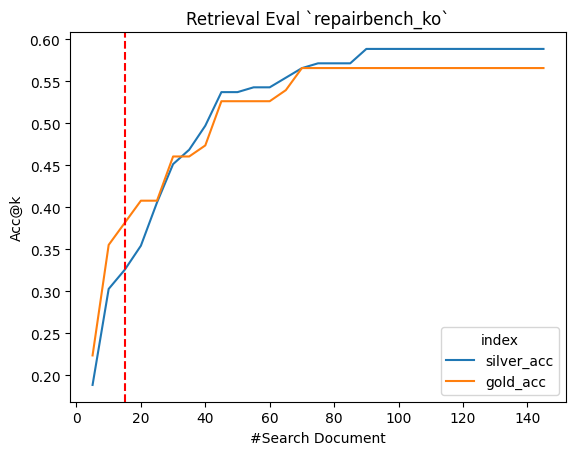

In [7]:
dset_name = 'repairbench_ko'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Retrieval Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=15, ymin=0, ymax=1, color='red', linestyle='--')
plt.show()

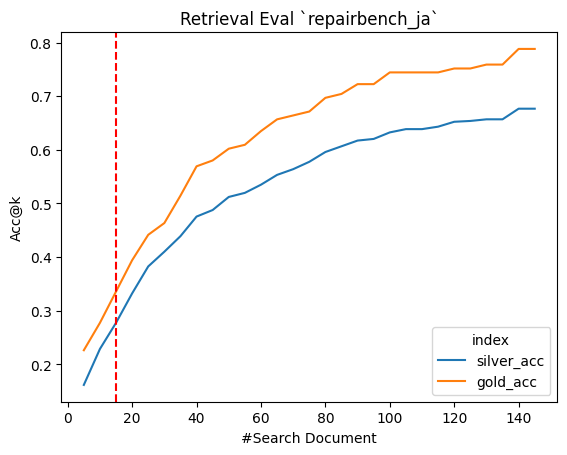

In [8]:
dset_name = 'repairbench_ja'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Retrieval Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=15, ymin=0, ymax=1, color='red', linestyle='--')
plt.show()

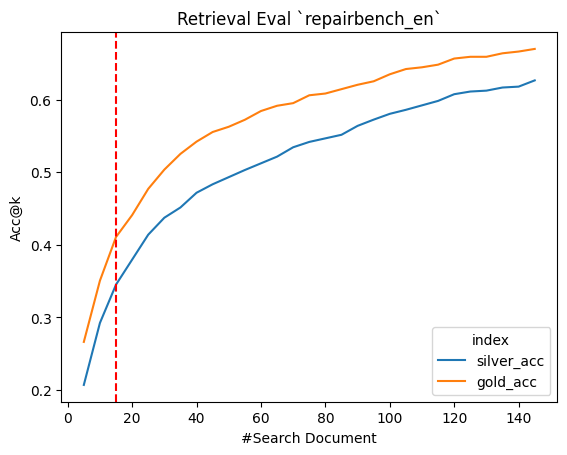

In [9]:
dset_name = 'repairbench_en'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Retrieval Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=15, ymin=0, ymax=1, color='red', linestyle='--')
plt.show()

# TF-IDF Retrieval Evaluation

In [18]:
# Build Index TF-IDF
docs_tfidf_dict = {}
docs_vector_dict = {}
for dset_name, docs_data in docs_data_dict.items():
    print(f'Building TF-IDF for `{dset_name}`')
    if dset_name == 'repairbench_ja':
        tfidf_vectorizer = TfidfVectorizer(analyzer='char')
    else:
        tfidf_vectorizer = TfidfVectorizer(analyzer='word')
    texts = list(map(lambda x: x['text'], docs_data))
    tokenized_corpus = [text.lower() for text in texts]
    docs_vector_dict[dset_name] = tfidf_vectorizer.fit_transform(tokenized_corpus)
    docs_tfidf_dict[dset_name] = tfidf_vectorizer

Building TF-IDF for `repairbench_ko`
Building TF-IDF for `repairbench_en`
Building TF-IDF for `repairbench_ja`


In [ ]:
# Initialize the TfidfVectorizer


# Fit and transform the corpus into a TF-IDF matrix
tfidf_corpus = tfidf_vectorizer.fit_transform(corpus)

# Transform the query into the same TF-IDF space
tfidf_query = tfidf_vectorizer.transform([query])

# Compute cosine similarity between the query and all documents
similarity_scores = cosine_similarity(tfidf_query, tfidf_corpus).flatten()

# Rank documents based on similarity scores
ranked_docs = sorted(
    zip(similarity_scores, corpus),
    key=lambda x: x[0],
    reverse=True
)

In [19]:
# Retrieval Evaluation Params
# test_data_dict: Dict<dataset_name, annotated_data_df>
# docs_data_dict: Dict<dataset_name, List<document_chunk>>
# docs_vector_dict: Dict<dataset_name>, CorpusTFIDF>
# docs_tfidf_dict: Dict<dataset_name, TfidfVectorizer>

ks = np.arange(5, 150, 5)
eval_dict = {}
for dset_name, test_df in test_data_dict.items():
    tfidf_vectorizer = docs_tfidf_dict[dset_name]
    docs_vectors = docs_vector_dict[dset_name]
    
    docs_uids = list(map(lambda x: f"{x['metadata']['filename']}_{x['metadata']['chunk_idx']}", docs_data_dict[dset_name]))
    silver_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['1', '2']]).tolist()
    gold_uids_list = test_df['data'].apply(lambda x: [f"{res['title']}_{res['chunk_idx']}" for res in x['search_results'][0] if res['is_relevant'] in ['2']]).tolist()

    docs_indices = []
    for row in test_df['data']:
        query = row['question']
        query_vector = tfidf_vectorizer.transform([query])
        scores = cosine_similarity(query_vector, docs_vectors).flatten()
        ranked_docs = sorted(
            filter(
                lambda x: x[0] > 0,
                zip(scores, [i for i in range(len(scores))])
            ),
            key=lambda x: x[0], reverse=True
        )
        docs_indices.append(list(map(lambda x: x[1], ranked_docs)))

    metrics = {}
    for k in ks:
        k_metrics = defaultdict(lambda: 0)
        for silver_uids, gold_uids, docs_idx in zip(silver_uids_list, gold_uids_list, docs_indices):
            if len(silver_uids) > 0:
                pred_uids = [docs_uids[idx] for idx in docs_idx[:k]]
                k_metrics[f'silver_correct'] += len(set(pred_uids).intersection(set(silver_uids)))
                k_metrics[f'silver_count'] += len(set(silver_uids))
            if len(gold_uids) > 0:
                pred_uids = [docs_uids[idx] for idx in docs_idx[:k]]
                k_metrics[f'gold_correct'] += len(set(pred_uids).intersection(set(gold_uids)))
                k_metrics[f'gold_count'] += len(set(gold_uids))
        metrics[k] = {
            'silver_acc': k_metrics[f'silver_correct'] / k_metrics[f'silver_count'], 
            'gold_acc': k_metrics[f'gold_correct'] /k_metrics[f'gold_count'],
        }
    eval_dict[dset_name] = dict(metrics)

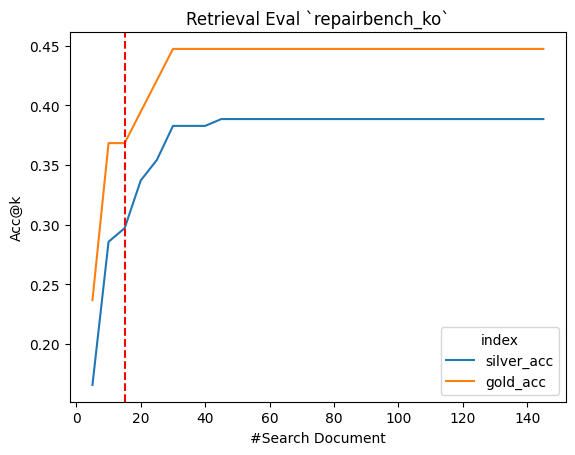

In [20]:
dset_name = 'repairbench_ko'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Retrieval Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=15, ymin=0, ymax=1, color='red', linestyle='--')
plt.show()

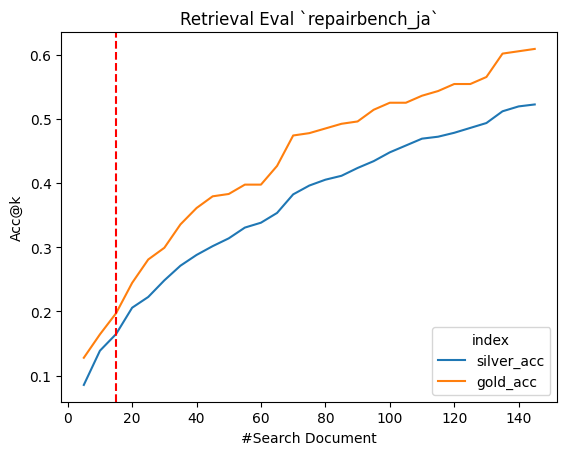

In [21]:
dset_name = 'repairbench_ja'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Retrieval Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=15, ymin=0, ymax=1, color='red', linestyle='--')
plt.show()

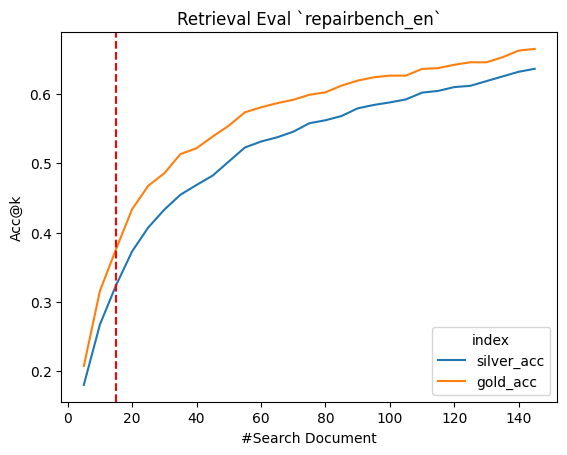

In [22]:
dset_name = 'repairbench_en'
df = pd.DataFrame(eval_dict[dset_name]).reset_index().melt(id_vars='index')
sns.lineplot(data=df, x='variable', y='value', hue='index')
plt.title(f'Retrieval Eval `{dset_name}`')
plt.xlabel('#Search Document')
plt.ylabel('Acc@k')
plt.axvline(x=15, ymin=0, ymax=1, color='red', linestyle='--')
plt.show()